## Project 3: Plausible Utopia 

### Classification Modeling on Subreddits to Classify Scientists and Futurists

### Notebook 1 of 3: Preprocessing, EDA 

#### Libary imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

### Preprocessing

#### Dataset 1: "New" submission type, pulled from Reddit on 10/20/20

In [2]:
subred_1 = pd.read_csv('../data/df_with_both_subs_1.csv')
display(pd.set_option('display.max_colwidth', 50), subred_1.head())

None

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,flavor
0,Robots Encroach on Up to 800 Million Jobs Arou...,10,jf13r9,https://www.bloombergquint.com/global-economic...,NaN,10,1.00,/r/Futurology/comments/jf13r9/robots_encroach_...,futurology,new
1,Measurement in AI Policy: Opportunities and Ch...,1,jf0178,https://youtu.be/UPNPHpawUCQ,NaN,1,0.66,/r/Futurology/comments/jf0178/measurement_in_a...,futurology,new
2,How Egypt is growing forests in middle of the ...,4,jeziml,https://www.al-monitor.com/pulse/originals/202...,NaN,4,0.83,/r/Futurology/comments/jeziml/how_egypt_is_gro...,futurology,new
3,Energy scavenging nanogenerator finds power al...,12,jeyzrd,https://phys.org/news/2020-10-energy-scavengin...,NaN,12,0.81,/r/Futurology/comments/jeyzrd/energy_scavengin...,futurology,new
4,There are political and cultural problems that...,4,jeyeez,https://www.reddit.com/r/Futurology/comments/j...,"Currently, the life expectancy in the US, cent...",4,0.84,/r/Futurology/comments/jeyeez/there_are_politi...,futurology,new


#### Dataset 2: "Controversial" submission type, pulled from Reddit on 10/20/20

In [3]:
subred_2 = pd.read_csv('../data/df_with_both_subs_2.csv')
display(pd.set_option('display.max_colwidth', 50), subred_2.head())

None

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,flavor
0,r/Futurology's Official Discord - A relaxed pl...,326,8r1jha,https://discordapp.com/invite/JtaYWC3,NaN,326,0.97,/r/Futurology/comments/8r1jha/rfuturologys_off...,futurology,controversial
1,Climate Change Mega-Thread,87,jag7ht,https://www.reddit.com/r/Futurology/comments/j...,Please post all climate change news here unles...,87,0.86,/r/Futurology/comments/jag7ht/climate_change_m...,futurology,controversial
2,The US government plans to file antitrust char...,13942,jep8br,https://www.theverge.com/2020/10/20/21454192/g...,NaN,13942,0.96,/r/Futurology/comments/jep8br/the_us_governmen...,futurology,controversial
3,"""Medicines that defeat aging have at least a 5...",28158,je6yaq,https://www.pairagraph.com/dialogue/952f0d6309...,NaN,28158,0.85,/r/Futurology/comments/je6yaq/medicines_that_d...,futurology,controversial
4,Energy scavenging nanogenerator finds power al...,38,jewchg,https://phys.org/news/2020-10-energy-scavengin...,NaN,38,0.97,/r/Futurology/comments/jewchg/energy_scavengin...,futurology,controversial


#### Dataset 3: "Top" submission type, pulled from Reddit on 10/20/20

In [4]:
subred_3 = pd.read_csv('../data/df_with_both_subs_3.csv')
display(pd.set_option('display.max_colwidth', 50), subred_3.head())

None

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,flavor
0,Elon Musk: We know we'll run out of dead dinos...,146990,a9rjmr,https://www.cnbc.com/2018/12/14/elon-musk-this...,NaN,146990,0.87,/r/Futurology/comments/a9rjmr/elon_musk_we_kno...,futurology,top
1,F.C.C. Announces Plan to Repeal Net Neutrality,146291,7ejbyf,https://www.nytimes.com/2017/11/21/technology/...,NaN,146291,0.90,/r/Futurology/comments/7ejbyf/fcc_announces_pl...,futurology,top
2,"Andrew Yang launches nonprofit, called Humanit...",103964,fdyn58,https://edition.cnn.com/2020/03/05/politics/an...,NaN,103964,0.84,/r/Futurology/comments/fdyn58/andrew_yang_laun...,futurology,top
3,"It's time to implement a 4-day workweek, Andre...",101762,i7usdh,https://www.businessinsider.com/andrew-yang-pa...,NaN,101762,0.87,/r/Futurology/comments/i7usdh/its_time_to_impl...,futurology,top
4,Biden will announce on Tuesday a new plan to s...,91318,hr4utb,https://www.nytimes.com/2020/07/14/us/politics...,NaN,91318,0.79,/r/Futurology/comments/hr4utb/biden_will_annou...,futurology,top


#### Combine dataframes

In [5]:
subred = pd.concat([subred_1, subred_2, subred_3])

# Modify the `flavor` column name to be more specific: new, controversial, etc. are submission types
subred['submission_type'] = subred['flavor']
subred.drop(columns = 'flavor', inplace = True)

subred.head()

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,submission_type
0,Robots Encroach on Up to 800 Million Jobs Arou...,10,jf13r9,https://www.bloombergquint.com/global-economic...,NaN,10,1.00,/r/Futurology/comments/jf13r9/robots_encroach_...,futurology,new
1,Measurement in AI Policy: Opportunities and Ch...,1,jf0178,https://youtu.be/UPNPHpawUCQ,NaN,1,0.66,/r/Futurology/comments/jf0178/measurement_in_a...,futurology,new
2,How Egypt is growing forests in middle of the ...,4,jeziml,https://www.al-monitor.com/pulse/originals/202...,NaN,4,0.83,/r/Futurology/comments/jeziml/how_egypt_is_gro...,futurology,new
3,Energy scavenging nanogenerator finds power al...,12,jeyzrd,https://phys.org/news/2020-10-energy-scavengin...,NaN,12,0.81,/r/Futurology/comments/jeyzrd/energy_scavengin...,futurology,new
4,There are political and cultural problems that...,4,jeyeez,https://www.reddit.com/r/Futurology/comments/j...,"Currently, the life expectancy in the US, cent...",4,0.84,/r/Futurology/comments/jeyeez/there_are_politi...,futurology,new


---

### EDA

In [6]:
for col in subred.columns[subred.dtypes == 'object']:
    print(col)

title
id
url
body
permalink
subreddit
submission_type


In [7]:
# Display count of nulls in columns, if any nulls appear (action item)
printmd('**Count of rows with null values, by column:**')
display(subred.isnull().sum()[subred.isnull().sum() > 0])
printmd('**Proportion of null values:**')
display(4544/subred.shape[0])

# Display datatypes
printmd('**Datatypes**')
display(subred.dtypes)

# Display columns whose datatype is object, aka string
# These are action items to clean, dummify or otherwise transform the data
printmd('**Names of columns with object (aka, string) datatype:**')
display(subred.columns[subred.dtypes == 'object'])

# Display summary statistics for the dataset's numeric columns
# Check reasonableness of data. Also check for outliers to drilldown on, clean or impute 
printmd('**Summary statistics:**')
display(subred.describe())

**Count of rows with null values, by column:**

body    4544
dtype: int64

**Proportion of null values:**

0.9711476811284463

**Datatypes**

title               object
score                int64
id                  object
url                 object
body                object
ups                  int64
upvote_ratio       float64
permalink           object
subreddit           object
submission_type     object
dtype: object

**Names of columns with object (aka, string) datatype:**

Index(['title', 'id', 'url', 'body', 'permalink', 'subreddit',
       'submission_type'],
      dtype='object')

**Summary statistics:**

,score,ups,upvote_ratio
count,4679.000000,4679.000000,4679.000000
mean,16575.650780,16575.650780,0.838788
std,23529.934678,23529.934678,0.113991
min,0.000000,0.000000,0.130000
25%,16.000000,16.000000,0.780000
50%,97.000000,97.000000,0.870000
75%,34647.500000,34647.500000,0.920000
max,199295.000000,199295.000000,1.000000


In [8]:
printmd("**`body` text is minimal, let's drop that column**")
display(subred.groupby('subreddit').count())
print('\n')
printmd('**The balance of classes is fairly balanced**')
subred['subreddit'].value_counts(normalize = True)

**`body` text is minimal, let's drop that column**

,title,score,id,url,body,ups,upvote_ratio,permalink,submission_type
subreddit,,,,,,,,,
futurology,2400,2400,2400,2400,120,2400,2400,2400,2400
science,2279,2279,2279,2279,15,2279,2279,2279,2279


**The balance of classes is fairly balanced**

futurology    0.51293
science       0.48707
Name: subreddit, dtype: float64

#### Address duplicates

In [9]:
printmd('**Instances of each title if the count is greater than 1:**')
duplicates = (pd.DataFrame(subred.groupby('title')['subreddit'].count())
                                .sort_values('subreddit', ascending = False))
duplicates = duplicates[duplicates['subreddit'] > 1]
duplicates

**Instances of each title if the count is greater than 1:**

,subreddit
title,
Scientists Found a New Way to Control the Brain With Light—No Surgery Required,6
"A rectangular robot as tiny as a few human hairs can travel throughout a colon by doing back flips, engineers have demonstrated in live animal models. Backflips because The goal is to use the robots to transport drugs in humans, whose colons and other organs have rough terrain. Side flips work, too.",6
"For the First Time Ever, Scientists Caught Time Crystals Interacting",4
Gravitational Test beyond the First Post-Newtonian Order with the Shadow of the M87 Black Hole,4
"Decent living for all does not have to cost the Earth. Global energy consumption in 2050 could be reduced to the levels of the 1960s and still provide a decent standard of living for a population three times larger, according to a new study.",4
...,...
"Experimental data shows that people who donate tend to be insensitive to efficacy because other people do not reward them for the efficacy. This explains why people give but do not give effectively. Social rewards for ""altruism"" tend to depend on well-defined and highly observable behaviours.",2
Dogs’ brains ‘not hardwired’ to respond to human faces. Study of brain activity shows no difference when dogs see back or front of a head,2
Domestication Phenotype Linked to Vocal Behavior in Marmoset Monkeys,2


In [10]:
# Zoom in on one specific duplicate to check its relevance to the problem statement

printmd('**I decided to drop the posts with duplicate titles because my intention is to see whether a classification model can predict classes based on vocabulary. If I were looking at the popularity or frequency of identical posts, I would keep the duplicates.**')
sample_duplicate = subred[subred['title'] == 'Scientists Found a New Way to Control the Brain With Light—No Surgery Required']
sample_duplicate

**I decided to drop the posts with duplicate titles because my intention is to see whether a classification model can predict classes based on vocabulary. If I were looking at the popularity or frequency of identical posts, I would keep the duplicates.**

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,submission_type
144,Scientists Found a New Way to Control the Brai...,26,jcrd27,https://singularityhub.com/2020/10/13/scientis...,NaN,26,0.82,/r/Futurology/comments/jcrd27/scientists_found...,futurology,new
260,Scientists Found a New Way to Control the Brai...,15,jazy6j,https://singularityhub.com/2020/10/13/scientis...,NaN,15,0.87,/r/Futurology/comments/jazy6j/scientists_found...,futurology,new
307,Scientists Found a New Way to Control the Brai...,100,jae1rs,https://singularityhub.com/2020/10/13/scientis...,NaN,100,0.98,/r/Futurology/comments/jae1rs/scientists_found...,futurology,new
142,Scientists Found a New Way to Control the Brai...,24,jcrd27,https://singularityhub.com/2020/10/13/scientis...,NaN,24,0.82,/r/Futurology/comments/jcrd27/scientists_found...,futurology,controversial
262,Scientists Found a New Way to Control the Brai...,11,jazy6j,https://singularityhub.com/2020/10/13/scientis...,NaN,11,0.78,/r/Futurology/comments/jazy6j/scientists_found...,futurology,controversial
292,Scientists Found a New Way to Control the Brai...,101,jae1rs,https://singularityhub.com/2020/10/13/scientis...,NaN,101,0.98,/r/Futurology/comments/jae1rs/scientists_found...,futurology,controversial


In [11]:
# Check out duplicated titles - there's a bunch!
subred[subred.duplicated(subset=['title'])].head()

printmd('**Count of unique titles:**')
display(subred['title'].nunique())
printmd('**Count of titles before dropping duplicates:**')
display(subred['title'].count())

non_title_cols = [col for col in subred.columns if col != 'title']

subred = subred.drop_duplicates(subset = ['title']).copy()

printmd('**Count of titles after dropping duplicates:**')
display(subred['title'].nunique())

printmd('**Shape of dataframe after dropping duplicates:**')
subred.shape

**Count of unique titles:**

3149

**Count of titles before dropping duplicates:**

4679

**Count of titles after dropping duplicates:**

3149

**Shape of dataframe after dropping duplicates:**

(3149, 10)

In [12]:
printmd('**Value counts:**')
display(subred['subreddit'].value_counts())

printmd('**Value counts by weight:**')
subred['subreddit'].value_counts(normalize = True)

**Value counts:**

futurology    1581
science       1568
Name: subreddit, dtype: int64

**Value counts by weight:**

futurology    0.502064
science       0.497936
Name: subreddit, dtype: float64

In [13]:
display(pd.set_option('display.max_colwidth', 30), subred.head())

None

,title,score,id,url,body,ups,upvote_ratio,permalink,subreddit,submission_type
0,Robots Encroach on Up to 8...,10,jf13r9,https://www.bloombergquint...,NaN,10,1.00,/r/Futurology/comments/jf1...,futurology,new
1,Measurement in AI Policy: ...,1,jf0178,https://youtu.be/UPNPHpawUCQ,NaN,1,0.66,/r/Futurology/comments/jf0...,futurology,new
2,How Egypt is growing fores...,4,jeziml,https://www.al-monitor.com...,NaN,4,0.83,/r/Futurology/comments/jez...,futurology,new
3,Energy scavenging nanogene...,12,jeyzrd,https://phys.org/news/2020...,NaN,12,0.81,/r/Futurology/comments/jey...,futurology,new
4,There are political and cu...,4,jeyeez,https://www.reddit.com/r/F...,"Currently, the life expect...",4,0.84,/r/Futurology/comments/jey...,futurology,new


In [14]:
# Null body rows
printmd(f"**Only {len(subred['body'][(subred['body'].isnull()).astype(int) == 0])} non-null `body` records. Ignore `body` column since there are so few in the dataset.**")

subred.drop(columns ='body', inplace = True)


**Only 72 non-null `body` records. Ignore `body` column since there are so few in the dataset.**

In [15]:
# Export for sentiment analysis (since the VADER library takes care of a lot of preprocessing steps)

subred.to_csv('../data/cleaned_df_for_sentiment_analysis.csv', index = False)

subred.shape

(3149, 9)

---

### Preprocessing
#### Remove content that likely does not help inform the classification result

#### Remove punctuation

In [16]:
# This function is going to remove punctuation and make the text lower case

def remove_punctuation(text):
    lower = text.lower()  
    exclude = string.punctuation  #identifies punctuation marks
    return "".join(ch for ch in lower if ch not in exclude) 
   
    #this iterates through each character, if the character is not a punctuation mark it will join to the empty string

subred['title'] = subred['title'].apply(remove_punctuation)

# ref: Heather Robinson at General Assembly :-)

subred['title'].head(5)

0    robots encroach on up to 8...
1    measurement in ai policy o...
2    how egypt is growing fores...
3    energy scavenging nanogene...
4    there are political and cu...
Name: title, dtype: object

#### Regex tokenizing

In [17]:
printmd('**Here we use a tokenizer that splits the text using regular expressions. It keeps the following:**')
printmd("`\D` = any character that is not a digit")
printmd("`w+` = any word character that occurs one or more times")

# Instantiate the tokenizer, define the function and apply it to the text
regexp_tokenizer = RegexpTokenizer('[\D]')

def regexp_tokenize(string):
    return ''.join(regexp_tokenizer.tokenize(string))

subred['title'] = subred['title'].apply(regexp_tokenize)
subred['title'].head()

**Here we use a tokenizer that splits the text using regular expressions. It keeps the following:**

`\D` = any character that is not a digit

`w+` = any word character that occurs one or more times

0    robots encroach on up to  ...
1    measurement in ai policy o...
2    how egypt is growing fores...
3    energy scavenging nanogene...
4    there are political and cu...
Name: title, dtype: object

**Stemming**

In [18]:
stemmer = PorterStemmer()  #instantiate stemmer

def split_and_stem(string):
    word = ""   #empty string
    string = string.split(' ') #creates list of words
    for i in string: #iterates through that list of words
        word += (stemmer.stem(i) + " ")  #stems each word and adds to empty string
    return word  #returns string with stemmed words

# Apply stemming to title 

subred['title'] = subred['title'].apply(split_and_stem)

# ref: Heather Robinson at General Assembly :-)

subred['title'].head()

0    robot encroach on up to  m...
1    measur in ai polici opport...
2    how egypt is grow forest i...
3    energi scaveng nanogener f...
4    there are polit and cultur...
Name: title, dtype: object

#### Check for balance of `submission_type` classes

In [19]:
printmd('**The balance of `submission_type` classes is basically even between `new` and `top`, and `controversial` is tiny**')
display(subred['submission_type'].value_counts(normalize = True))

printmd('**Before the drop: Are there any `controversial` titles worth keeping? By a very subjective process of elimination, I am deciding to drop all these titles**')

(display(pd.set_option('display.max_colwidth', 500), 
        pd.DataFrame(subred[subred['submission_type'] == 'controversial']['title'])))

# New dataframe only contains rows where submission_type is not controversial
subred = subred[subred['submission_type'] != 'controversial']

printmd('**After the drop:**')
printmd('**`submission_type`**')
display(subred['submission_type'].value_counts())
display(subred['submission_type'].value_counts(normalize = True))

**The balance of `submission_type` classes is basically even between `new` and `top`, and `controversial` is tiny**

new              0.501429
top              0.494760
controversial    0.003811
Name: submission_type, dtype: float64

**Before the drop: Are there any `controversial` titles worth keeping? By a very subjective process of elimination, I am deciding to drop all these titles**

None

,title
0,rfuturolog offici discord a relax place to chill and discuss all thing futurolog
744,south korea will launch g trial in with tbp speed and th latenc of g
778,a team of nasa research seek a new energi sourc for deepspac explor mission recent reveal a method for trigger nuclear fusion in the space between the atom of a metal solid
784,money is worth noth now how lebanon is find a futur in farm
788,weve long wait for fusion thi reactor may final deliv it—fast scientist say their compact reactor could be up and run in just year that would be unpreced
793,the sever downturn in air traffic thi year caus by covid follow by a slow recoveri will result in a loss of up to million job normal support by aviat around the globe accord to new industri figur releas today
799,satir is dead hopium will be the name of thi futur french hydrogen car meant to compet with tesla model s
832,bing drink caus liver damag by reduc cellular level of nad
1475,use weed dure pregnanc link to psychoticlik behavior in children studi find studi of children
1476,transmiss dynam reveal the impract of covid herd immun strategi a new studi simul sarscov spread in the uk find that achiev herd immun without overwhelm hospit capac leav littl room for error


**After the drop:**

**`submission_type`**

new    1579
top    1558
Name: submission_type, dtype: int64

new    0.503347
top    0.496653
Name: submission_type, dtype: float64

#### Add a word count column in case it has any significance 

In [20]:
subred['title_word_count'] = subred['title'].apply(lambda x: len(x.split()))

#### Binarizing the target feature: `1` for Science, `0` for Futurology

In [21]:
# Check the balance of classes

printmd('**`title`**')
display(subred['subreddit'].value_counts())
display(subred['subreddit'].value_counts(normalize = True))

# subred['subreddit'] = subred['subreddit'].map({'science': 1, 'futurology': 0})

# printmd('**Balance of classes after binarizing (Science: 1, Futurology: 0)**')
# display(subred['subreddit'].value_counts(normalize = True))

**`title`**

futurology    1574
science       1563
Name: subreddit, dtype: int64

futurology    0.501753
science       0.498247
Name: subreddit, dtype: float64

In [22]:
printmd(f"### The baseline accuracy score is {subred['subreddit'].value_counts(normalize = True)[0]:.3f}")

printmd(f"### The simplest model is to predict only the majority class (`futurology`). If we used that model, the predictions would be {subred['subreddit'].value_counts(normalize = True)[0]:.3f} accurate.")
printmd('### We will use this benchmark to compare against the scores that our models generate.')

### The baseline accuracy score is 0.502

### The simplest model is to predict only the majority class (`futurology`). If we used that model, the predictions would be 0.502 accurate.

### We will use this benchmark to compare against the scores that our models generate.

In [23]:
subred_for_models = subred[['subreddit', 'title']]

subred_for_models.to_csv('../data/cleaned_data/cleaned_df.csv', index = False)

### Cutoff point 

#### To toggle refresh data if needed:
Click on this cell, then select the following from the Jupyter Notebook menu:  `Cell`  > `Run all above`


---

#### Set the features and target variable

In [24]:
# Set feature matrix and target variable

X = subred['title']
y = subred['subreddit']

## EDA



In [25]:
# Binarize the target column
subred['subreddit'] = subred['subreddit'].map({'science': 1, 'futurology': 0})

In [26]:
# Create a dataframe with columns relevant to EDA

subred_for_eda = subred[['title', 'score', 'upvote_ratio', 'ups', 'submission_type', 'subreddit', 'title_word_count']]
display(subred_for_eda.head(1))

printmd(f'**Shape of data for EDA is {subred_for_eda.shape[0]} rows, {subred_for_eda.shape[1]} features**')

,title,score,upvote_ratio,ups,submission_type,subreddit,title_word_count
0,robot encroach on up to million job around the world,10,1.0,10,new,0,10


**Shape of data for EDA is 3137 rows, 7 features**

### Before vectorizing words, let's check out numerical values in the dataset

In [27]:
printmd('**No strong correlations with the `subreddit` target column, but we do need to drop the `score` columns (duplicate of `ups`)**')

display(subred_for_eda.corr()['subreddit'])

# # Confirm the two columns are the same
# subred_for_eda[['ups', 'score']].sum()

# # Drop `score`
# subred_for_eda.drop(columns = 'score', inplace = True)

**No strong correlations with the `subreddit` target column, but we do need to drop the `score` columns (duplicate of `ups`)**

score               0.199984
upvote_ratio       -0.027595
ups                 0.199984
subreddit           1.000000
title_word_count    0.262234
Name: subreddit, dtype: float64

In [28]:
printmd('**The mean number of ups for the `top` category is much higher than the others (aptly named!)**')
submission_type_means = subred_for_eda.groupby('submission_type').mean()
submission_type_means

**The mean number of ups for the `top` category is much higher than the others (aptly named!)**

,score,upvote_ratio,ups,subreddit,title_word_count
submission_type,,,,,
new,2064.671944,0.811995,2064.671944,0.500317,21.034199
top,44386.410783,0.885687,44386.410783,0.496149,31.431964


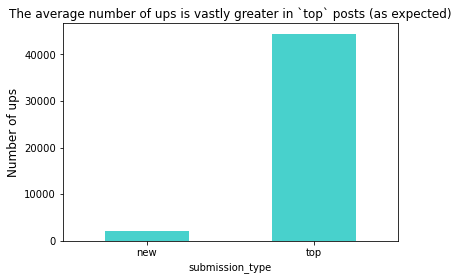

In [29]:
plt.figure(figsize=[6, 4])

submission_type_means['ups'].plot(kind = 'bar', color = 'mediumturquoise')

plt.title('The average number of ups is vastly greater in `top` posts (as expected)')
plt.ylabel('Number of ups', size = 12)
plt.xticks(rotation = 0);

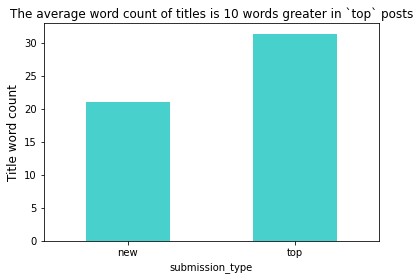

In [30]:
plt.figure(figsize=[6, 4])

submission_type_means['title_word_count'].plot(kind = 'bar', color = 'mediumturquoise')

plt.title('The average word count of titles is 10 words greater in `top` posts')
plt.ylabel('Title word count', size = 12)
plt.xticks(rotation = 0);

Text(0.5, 0, 'Number of ups')

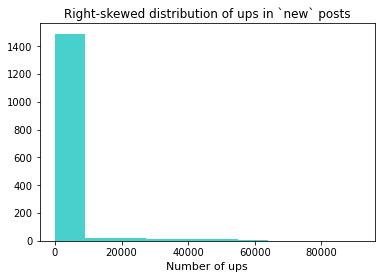

In [31]:
plt.hist(subred_for_eda[subred_for_eda['submission_type'] == 'new']['ups'], color = 'mediumturquoise')
plt.title('Right-skewed distribution of ups in `new` posts', size = 12)
plt.xlabel('Number of ups', size = 11)

Text(0.5, 0, 'Number of ups')

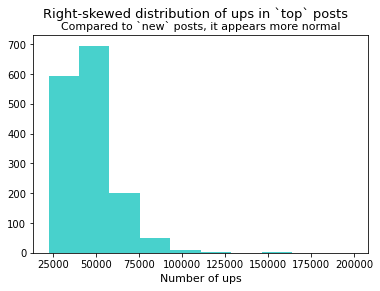

In [32]:
plt.hist(subred_for_eda[subred_for_eda['submission_type'] == 'top']['ups'], color = 'mediumturquoise')
plt.suptitle('Right-skewed distribution of ups in `top` posts', size = 13)
plt.title("Compared to `new` posts, it appears more normal", size = 11)
plt.xlabel('Number of ups', size = 11)

### Bag of Words analysis

#### CountVectorizer

1. Count number of times a token is observed in a given subreddit post

2. Create a vector to store those counts

In [33]:
subred = subred[['title', 'subreddit']]

**Custom stop words**

In [34]:
# A meaningless 'ha' showed up in the vocabulary (probably for the words 'has', 'have', etc.). I'd prefer to ignore that.

my_additional_stop_words = ['ha']

standard_and_custom_stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

# ref: https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list

#### Create a document-term matrix to match up the subreddits and words

In [35]:
# Apply stemming to the `title` column
subred['title'] = subred['title'].apply(split_and_stem)

# Joins all stemmed text from `title` column, groups by `subreddit` column
subred_grouped_by_sub = subred[['subreddit', 'title']].groupby(by = 'subreddit').agg(lambda x: ' '.join(x))

# Instantiate CountVectorizer
cv = CountVectorizer(
                     analyzer = 'word',
                     stop_words = standard_and_custom_stop_words,
                     ngram_range = (1, 2),
                    )

# Fit the `title` column to the vocabulary (aka, learn it), transform words/ n-grams into vectors
subred_grouped_by_sub_new = cv.fit_transform(subred_grouped_by_sub['title'])

# Set up document-term matrix dataframe that pairs word vectors with their count in each `subreddit`
df_doc_term_matrix = pd.DataFrame(subred_grouped_by_sub_new.todense(), columns = cv.get_feature_names())

# Bring `subreddit` back into the dataframe
df_doc_term_matrix['subreddit'] = subred_grouped_by_sub.index
subreddit_col = df_doc_term_matrix.pop('subreddit')
df_doc_term_matrix.insert(0, 'subreddit', subreddit_col)

df_doc_term_matrix

# ref: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

,subreddit,aaa,aaa scientist,aalto,aalto univ,ab,ab increa,abandon,abandon coal,abandon invest,abandon land,abandon leav,abandon stay,abdomen,abdomen larg,abduct,abduct neardeath,aberdeen,aberdeen citi,aberr,aberr new,aberr synapt,abet,abet spread,abil,abil absorb,abil academ,abil adequ,abil connect,abil contract,abil control,abil cooper,abil current,abil deepfak,abil delay,abil evalu,abil fight,abil identifi,abil invad,abil lemur,abil magic,abil maintain,...,zeroemiss,zeroemiss fuel,zeroemiss mark,zeroemiss plane,zeroemiss vehicl,zerotol,zerotol messag,zhengzhou,zhengzhou railway,zika,zika like,zinc,zinc author,zinc children,zinc zn,ziplin,ziplin unit,zircon,zircon hyperson,zn,zn base,zombi,zombi fires,zombi gene,zombi occur,zone,zone diver,zone estuari,zone exceed,zone saw,zoologist,zoologist uncov,zoonot,zoonot transmiss,zuckerberg,zuckerberg differ,zurbuchen,zurbuchen nasa,αcmₚmₑ½,αcmₚmₑ½ km,μg,μg dose
0,0,1,1,0,0,0,0,4,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,5,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,...,4,1,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,2,1,0,1,2,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0
1,1,0,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,1,0,1,0,0,25,0,1,1,1,1,1,1,1,0,2,1,1,1,1,2,0,0,...,0,0,0,0,0,1,1,0,0,0,0,2,1,1,0,0,0,0,0,0,0,1,0,1,0,2,0,0,1,1,1,1,1,1,0,0,0,0,1,1,2,2


#### Most common words

,peopl,use,research,studi,new
futurology,63,130,82,41,211
science,199,204,263,499,487


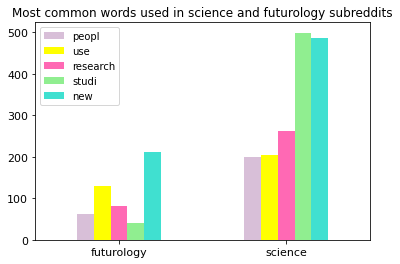

In [38]:
# Most common words used in science and futurology subreddits

top_words = df_doc_term_matrix.iloc[:, 1:].sum().sort_values(ascending = False)[:5][::-1]
top_words = df_doc_term_matrix[[word for word in pd.Series(top_words).index]]
top_words.index = ['futurology', 'science']
display(top_words)

colors_fiver = ['thistle', 'yellow', 'hotpink', 'lightgreen', 'turquoise']

top_words.plot.bar(color = colors_fiver)

plt.title('Most common words used in science and futurology subreddits')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11)
plt.savefig('../images/top_words.png');

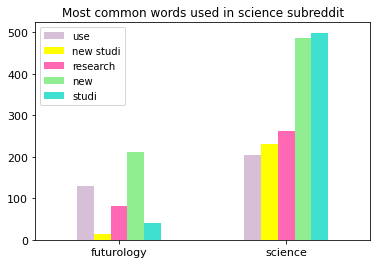

In [1961]:
# Most common words used in science subreddit

top_words_science_only = (df_doc_term_matrix.iloc[:, 1:][df_doc_term_matrix['subreddit'] == 1]
                                            .sum().sort_values(ascending = False)[:5][::-1])
                    
top_words_science_only = df_doc_term_matrix[[word for word in pd.Series(top_words_science_only).index]]
top_words_science_only.index = ['futurology', 'science']
top_words_science_only

top_words_science_only.plot.bar(color = colors_fiver)

plt.title('Most common words used in science subreddit')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11)
plt.savefig('../images/top_words_science_only.png');

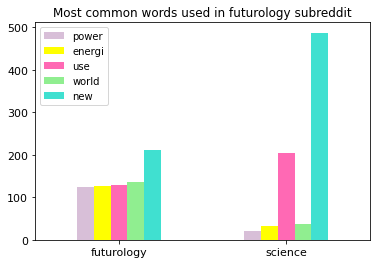

In [1962]:
# Most common words used in futurology subreddit

top_words_futurology_only = (df_doc_term_matrix.iloc[:, 1:][df_doc_term_matrix['subreddit'] == 0]
                                            .sum().sort_values(ascending = False)[:5][::-1])

top_words_futurology_only = df_doc_term_matrix[[word for word in pd.Series(top_words_futurology_only).index]]
top_words_futurology_only.index = ['futurology', 'science']
top_words_futurology_only

top_words_futurology_only.plot.bar(color = colors_fiver)

plt.title('Most common words used in futurology subreddit')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11)
plt.savefig('../images/top_words_futurology_only.png');

#### Distribution of post lengths

Text(0.5, 0, 'Title word count')

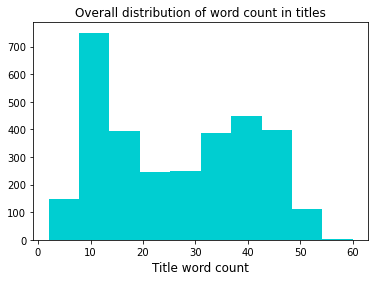

In [1963]:
plt.figure(figsize=[6, 4])

subred_for_eda['title_word_count'].hist(color = 'darkturquoise', grid = False)

plt.title('Overall distribution of word count in titles')
plt.xlabel('Title word count', size = 12)

#### Use of arbitrary terms one might guess are common in either subreddit

In [1967]:
display(df_doc_term_matrix.groupby(by = 'subreddit')['scienc', 'scientist', 'futur', 'tech', 'technology'].sum())
printmd('**Surprisingly low.. This can partly be explained by the fact I used bigrams in the CountVectorizer transformation. See next steps below.**')

,scienc,scientist,futur,tech,technology
subreddit,,,,,
0,33,77,111,31,1
1,31,128,19,1,0


**Surprisingly low.. This can partly be explained by the fact I used bigrams in the CountVectorizer transformation. See next steps below.**

### For fun: Niche points of interest // Pseudo topic modeling

**Next steps: Feature engineering**

* Group unigrams and bigrams into topic-based sets to get a more context-rich custom vocabulary

In [1966]:
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'alien' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'analys' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'ancient' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'arctic' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'antibod' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'apocal' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'best' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'better' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'covid' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'death' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'digit' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'dream' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'dysto' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'futur' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'govern' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'plaus' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'utop' in col]])


,alien,alien abduct,alien civil,alien futur,alien life,alien like,alien nonn,alien speci,alien world,discoveri alien,earth alien,listen alien,number alien,religi alien,search alien,secur alien,travel alien
0,6,0,1,1,2,1,0,0,1,1,1,1,0,0,1,1,1
1,3,1,0,0,0,0,1,1,0,0,0,0,2,1,0,0,0


,accord analysi,analysi,analysi ancient,analysi autism,analysi babi,analysi brainboost,analysi canadian,analysi clinic,analysi combin,analysi cultur,analysi dark,analysi data,analysi deepfak,analysi evolut,analysi histor,analysi indic,analysi itd,analysi literatur,analysi lower,analysi medicaid,analysi million,analysi millionyearold,analysi myalgic,analysi noscapin,analysi onefifth,analysi purpo,analysi registri,analysi reveal,analysi robust,analysi thi,analysi trump,analysi uncomfort,analysi use,analysi wa,analyst,analyst invest,analyst said,ape analysi,arrest analysi,belgium analysi,bodi analysi,cave reanalysi,collap analysi,compar analysi,comprehen analysi,corpu analysi,cost analysi,crime analysi,data analysi,disord metaanalysi,effect analysi,energi analyst,experi metaanalysi,explan analysi,genet analysi,herit analysi,metaanalysi,metaanalysi studi,multispectr analysi,municipalsc analysi,nanocellulo analysi,network analysi,new analysi,note analyst,peerreview analysi,pew analysi,pioneer analysi,reanalysi,reanalysi remain,reward analysi,sinc analysi,swathm analysi,univ analysi,week analysi
0,0,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0
1,2,31,1,1,1,1,1,1,1,0,1,2,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,2,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,2,1,2,2,1,1,1,1,3,0,1,0,1,1,1,1,1,1,1,1


,american ancient,analysi ancient,ancient,ancient ancestor,ancient beringian,ancient black,ancient denisovan,ancient dna,ancient egypt,ancient eleph,ancient gene,ancient group,ancient hominin,ancient human,ancient leather,ancient magnet,ancient megalodon,ancient parasit,ancient persia,ancient pollen,ancient stump,ancient teenag,ancient underwat,ancient whale,bone ancient,clone ancient,discov ancient,entangl ancient,evid ancient,fossil ancient,haplotyp ancient,home ancient,hygien ancient,import ancient,investig ancient,light ancient,massiv ancient,moon ancient,occur ancient,proof ancient,reconstruct ancient,tumor ancient,unknown ancient,wa ancient
0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,1,20,0,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1


,age arctic,antarctica,antarctica alon,antarctica scaveng,antarctica studi,antarctica year,arctic,arctic circl,arctic climat,arctic hasn,arctic ocean,arctic seed,arctic shift,arctic shown,arctic suggest,chang arctic,discov antarctica,discov arctic,doomsday arctic,instead arctic,just antarctica,microb antarctica,penguin antarctica,rise arctic,russian arctic,soil arctic
0,0,0,0,0,0,0,6,1,1,1,1,1,0,0,1,1,0,1,1,1,0,0,0,1,0,1
1,1,4,1,1,1,1,2,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,1,0,1,0


,abund antibodi,adult antibodi,antibodi,antibodi attack,antibodi compar,antibodi cough,antibodi diagno,antibodi immun,antibodi neutral,antibodi persist,antibodi produc,antibodi profil,antibodi protect,antibodi respon,antibodi safe,antibodi sampl,antibodi sarscov,antibodi serum,antibodi specif,antibodi strengthen,antibodi target,antibodi tcell,antibodi treatment,antibodi viru,antibodi yearold,autoantibodi,autoantibodi type,bind neutralizingantibodi,covid antibodi,develop antibodi,elicit antibodi,evid antibodi,fewer antibodi,form antibodi,highqual antibodi,igg antibodi,immun antibodi,inject antibodi,like antibodi,make antibodi,model autoantibodi,mutat antibodi,neutralizing antibodi,neutralizingantibodi,neutralizingantibodi titer,produc antibodi,product antibodi,sarscov antibodi,serum antibodi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,23,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,1


,apocalyp,apocalyp driven,apocalyp ignor,apocalypse,apocalypse declin,harb apocalyp,insect apocalyp,insect apocalypse,oper postapocalyp,postapocalyp,postapocalyp oper
0,1,1,0,0,0,0,1,0,1,1,1
1,1,0,1,1,1,1,0,1,0,0,0


,adopt best,appli best,asbesto,asbesto power,best,best candid,best climat,best envisag,best friend,best global,best hope,best possibl,best power,best recommend,best research,best result,best solar,best way,best year,bestperform,bestperform formul,chang asbesto,distract best,distribut best,dumbest,dumbest experi,everyon best,hawk best,higher best,human best,know best,need best,planet best,right dumbest,say best,scientist best,snap best,space best,stabil bestperform,studi best,weight best,world best
0,1,1,1,1,8,0,1,1,0,1,1,0,1,0,0,0,1,1,1,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1
1,0,0,0,0,10,1,0,0,2,0,0,2,0,1,1,1,0,2,0,1,1,0,0,1,0,0,1,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0


,achiev better,allow better,better,better abl,better academ,better access,better adult,better born,better bring,better calcul,better chanc,better children,better coloni,better current,better cut,better day,better decad,better earth,better educ,better fossil,better gentli,better given,better glycaem,better guid,better health,better healthcar,better higher,better human,better immedi,better job,better just,better learn,better life,better littl,better medic,better mind,better norm,better obe,better orgasm,better partial,better peopl,better pharmaceut,...,deliv better,develop better,dog better,experi better,extrem better,far better,feel better,grew better,healthier better,help better,intellig better,jog better,learn better,link better,make better,marijuana better,medic better,men better,million better,movement better,parent better,patient better,perform better,planet better,prefer better,preschool better,quickli better,rate better,realli better,recov better,save better,scientist better,similar better,skill better,sleep better,someth better,subordin better,surgeri better,testtak better,wa better,way better,work better
0,0,0,18,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,2,0,0,0,1,0,0,1,0,0,...,1,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,1,2
1,1,1,43,1,1,0,2,1,1,1,1,1,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,...,0,1,0,0,1,1,1,0,1,1,1,1,1,1,2,1,1,1,1,1,1,1,5,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1,1,1,0,0


,achiev covid,admiss covid,affect covid,alexa covid,amid covid,appear covid,associ covid,attribut covid,august covid,autopsi covid,befor covid,billion covid,brandvoic covid,case covid,catch covid,cau covid,center covid,chang covid,children covid,chine covid,coauthor covid,cohort covid,compliant covid,confirm covid,contribut covid,conver covid,counter covid,covid,covid accord,covid american,covid antibodi,covid associ,covid basic,covid becom,covid broke,covid cardiac,covid case,covid cau,covid children,covid clinic,covid conceptu,covid confirm,...,postcovid syndrom,prebunks covid,predict covid,present covid,prevent covid,procrastin covid,rate covid,reinfect covid,relat covid,remain covid,remedi covid,republican postcovid,research covid,respon covid,result covid,reviv covidriddl,rise covid,risk covid,sarscov covid,sarscov covidnudg,say covid,sent covid,seriou covid,sever covid,slow covid,sourc covid,spread covid,state covid,studi covid,suscept covid,thi covid,tourism postcovid,treatment covid,trial covid,trust covid,univ covid,valid covid,wave covid,work covid,world covid,zealand covid,zeptosecond covid
0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0
1,1,1,1,0,0,1,2,1,1,1,1,0,0,1,1,4,1,1,1,1,1,1,1,1,1,1,1,173,1,1,1,1,1,1,0,1,6,4,1,1,1,1,...,1,1,1,1,3,1,2,1,1,0,1,1,1,1,1,0,2,3,1,1,1,1,2,9,0,1,6,1,4,1,0,0,4,1,1,1,1,2,1,0,0,1


,abduct neardeath,addit death,averag death,bird death,bring death,cancer death,care death,case death,categori death,cau death,cell death,contribut death,counti death,covid death,cut death,death,death accord,death ani,death associ,death attribut,death billion,death brain,death capita,death certif,death citi,death close,death code,death compar,death covid,death crucial,death exerci,death experi,death flu,death grow,death harm,death help,death men,death metal,death new,death number,death offici,death older,...,death relat,death scene,death state,death switch,death taser,death tobacco,death unfortun,death year,deathbig,deathbig bang,deaths,deaths highest,doubt death,event death,everi death,excess death,excess deaths,far death,fewer death,futur death,heat deathbig,ill death,increa death,infant death,infect death,lineofduti death,minut death,morbid death,near death,neardeath,neardeath context,number death,offici death,opioid death,peak death,prematur death,probabl death,reinfect death,risk death,talli death,text death,trigger death
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,1,1,1,1,1,1,1,1,4,1,45,1,2,2,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,...,1,1,1,1,1,1,1,4,0,0,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,4,1,1,1


,activefeedback digit,cancer digit,checkout digit,chip digit,digit,digit ad,digit asset,digit book,digit control,digit data,digit dream,digit end,digit intellig,digit patholog,digit piecework,digit republic,digit right,digit rodent,digit skill,digit stroke,digit trend,digit twin,estonia digit,goe digit,gpt digit,head digit,intellig digit,modul digit,new digit,propo digit,recognit digit,simul digit,tax digit,use digit,utopian digit,vr digit,walmart digit
0,0,1,1,1,15,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,2,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,1
1,1,0,0,0,4,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0


,daydream,daydream actual,digit dream,dream,dream accord,dream cluster,dream decentr,dream dream,dream dystopian,dream form,dream imageri,dream neg,echo dream,heighten dream,inevit dream,men dream,peopl dream,profess daydream,women dream
0,0,0,1,2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
1,1,1,0,6,1,1,0,1,0,1,1,1,1,1,0,1,1,1,1


,credit dystopian,dream dystopian,dystopian,dystopian disast,dystopian inequ,dystopian nightmar,dystopian societi,exampl dystopian,porn dystopian
0,1,1,4,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0


,act futur,affect futur,ahead futurist,ai futur,alien futur,america futur,attempt futurist,bacteria futur,believ futur,bet futur,build futurist,busi futur,busi futureproof,car futur,carbonneutr futur,career futur,cashless futur,children futur,china futur,chip futur,citi futur,compon futur,comput futur,corp futur,countri futur,creat futur,creat futurist,crispr futur,cyborg futur,cybunk futur,democraci futur,depress futur,destroy futur,discuss futur,domin futur,electron futur,energi futur,engin futur,ensur futur,entir futurist,envi futur,environ futur,...,plant futur,platform futurolog,potenti futur,power futur,predict futur,present futur,process futur,propel futur,push futur,remov futur,resid futur,reveal futurecraft,reward futurist,room futur,save futur,scienc futur,second futur,selfsuffici futur,sell futur,shape futur,socialist futur,stake futur,steal futur,stuff futur,subject futur,superbatteri futur,support futurist,sustain futur,tast futur,technolog futur,tesla futur,think futurist,thought futur,travel futur,undoubtedli futur,use futur,video futur,vision futur,whi futur,won future,world futur,year futur
0,1,1,1,1,1,1,1,0,0,1,1,1,1,2,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,1,0,1,2,1,1,1,1,...,1,1,1,4,1,1,1,1,2,0,1,1,1,1,2,2,0,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


,accord govern,ai govern,area govern,ban govern,california governor,canadian govern,car govern,coal govern,cocacola govern,collap govern,control govern,country govern,crisi government,deci govern,directli govern,fbi govern,feder govern,form govern,french govern,fund govern,globe govern,govern,govern account,govern action,govern allow,govern approv,govern begun,govern buy,govern children,govern climat,govern covid,govern describ,govern evid,govern facial,govern far,govern forc,govern geograph,govern impo,govern insist,govern invest,govern mar,govern minist,...,governor sign,greek govern,head govern,heard govern,help govern,hold govern,home govern,inact govern,increa govern,invest govern,landscap govern,led govern,local govern,martian govern,new govern,obe govern,ottoman govern,ourselv govern,plant govern,plate govern,politician govern,price govern,provid govern,repr government,requir govern,research govern,revenu govern,sale govern,satisfact govern,scottish govern,selfgovern,selfgovern counter,sever govern,state govern,state governor,structur selfgovern,su govern,time govern,uk govern,uk government,welsh govern,world government
0,1,1,0,2,1,1,1,1,1,0,1,1,1,0,1,1,3,1,1,0,1,41,1,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,1,1,...,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,1,1
1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,16,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0


,invent plausibl,plausibl,plausibl utopia
0,1,1,1
1,0,0,0


,ahead utopian,autopilot,autopilot dure,autopilot featur,autopilot research,autopilot tesla,autopilot time,autopsi,autopsi covid,autopsi studi,disabl autopilot,dure autopsi,mile autopilot,plausibl utopia,player autopsi,tesla autopilot,utopia,utopia anatomi,utopian,utopian digit
0,1,5,1,1,1,1,1,0,0,0,1,0,1,1,0,3,1,1,1,1
1,0,0,0,0,0,0,0,2,1,1,0,1,0,0,1,0,0,0,0,0
